# Imports

In [31]:
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torchaudio.transforms as T

import glob
from pathlib import Path
from tqdm.auto import tqdm
from sklearn.metrics import roc_auc_score

In [32]:
%load_ext autoreload
%autoreload 2

import sys
import os
    
src_abspath = os.path.abspath('..')

if src_abspath not in sys.path:
    sys.path.append(src_abspath)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
from hydra import initialize, compose
from omegaconf import OmegaConf

with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name="config")
    print(cfg)

{'data': {'window_size': 1024, 'overlap': 256, 'spectral': False, 'sample_rate': 20000, 'f_max': 5000, 'n_mels': 64, 'chunk_size': 8192, 'chunk_overlap': 6144}}


In [34]:
DATA_PATH = "../data/2nd_test/"

files = os.listdir(DATA_PATH)
files = sorted(files)

data = pl.read_csv(Path(DATA_PATH) / files[0], has_header=False, separator='\t')

# AE

## RAW

In [5]:
from src.autoencoders.datasets import NASAIMSRawDataset, get_nasa_stats
from src.autoencoders import train_loop
from src.unet1d import load_save, model

In [6]:
healthy_frac = 0.3
healthy_files = [Path(DATA_PATH) / el for el in files[:int(len(files) * healthy_frac)]]

val_frac = 0.2
val_files = [Path(DATA_PATH) / el for el in files[int(len(files) * healthy_frac) :  int(len(files) * (healthy_frac + val_frac))]]

bad_frac = 0.3
bad_files = [Path(DATA_PATH) / el for el in files[int(len(files) * (healthy_frac + val_frac)):]]


z_norm_params = get_nasa_stats(healthy_files)

ds0 = NASAIMSRawDataset(healthy_files, cfg.data.window_size, cfg.data.overlap, 0, mu=z_norm_params["b1_mean"], sigma=z_norm_params["b1_std"])
ds1 = NASAIMSRawDataset(healthy_files, cfg.data.window_size, cfg.data.overlap, 1, mu=z_norm_params["b2_mean"], sigma=z_norm_params["b2_std"])
ds2 = NASAIMSRawDataset(healthy_files, cfg.data.window_size, cfg.data.overlap, 2, mu=z_norm_params["b3_mean"], sigma=z_norm_params["b3_std"])
ds3 = NASAIMSRawDataset(healthy_files, cfg.data.window_size, cfg.data.overlap, 3, mu=z_norm_params["b4_mean"], sigma=z_norm_params["b4_std"])

val_ds0 = NASAIMSRawDataset(val_files, cfg.data.window_size, cfg.data.overlap, 0, mu=z_norm_params["b1_mean"], sigma=z_norm_params["b1_std"])
val_ds1 = NASAIMSRawDataset(val_files, cfg.data.window_size, cfg.data.overlap, 1, mu=z_norm_params["b2_mean"], sigma=z_norm_params["b2_std"])
val_ds2 = NASAIMSRawDataset(val_files, cfg.data.window_size, cfg.data.overlap, 2, mu=z_norm_params["b3_mean"], sigma=z_norm_params["b3_std"])
val_ds3 = NASAIMSRawDataset(val_files, cfg.data.window_size, cfg.data.overlap, 3, mu=z_norm_params["b4_mean"], sigma=z_norm_params["b4_std"])

bad_ds0 = NASAIMSRawDataset(bad_files, cfg.data.window_size, cfg.data.overlap, 0, mu=z_norm_params["b1_mean"], sigma=z_norm_params["b1_std"])
bad_ds1 = NASAIMSRawDataset(bad_files, cfg.data.window_size, cfg.data.overlap, 1, mu=z_norm_params["b2_mean"], sigma=z_norm_params["b2_std"])
bad_ds2 = NASAIMSRawDataset(bad_files, cfg.data.window_size, cfg.data.overlap, 2, mu=z_norm_params["b3_mean"], sigma=z_norm_params["b3_std"])
bad_ds3 = NASAIMSRawDataset(bad_files, cfg.data.window_size, cfg.data.overlap, 3, mu=z_norm_params["b4_mean"], sigma=z_norm_params["b4_std"])



Reading files:   0%|          | 0/295 [00:00<?, ?it/s]

Loading 295 files into memory...


  0%|          | 0/295 [00:00<?, ?it/s]

Dataset loaded. Total windows: 7670
Loading 295 files into memory...


  0%|          | 0/295 [00:00<?, ?it/s]

Dataset loaded. Total windows: 7670
Loading 295 files into memory...


  0%|          | 0/295 [00:00<?, ?it/s]

Dataset loaded. Total windows: 7670
Loading 295 files into memory...


  0%|          | 0/295 [00:00<?, ?it/s]

Dataset loaded. Total windows: 7670
Loading 197 files into memory...


  0%|          | 0/197 [00:00<?, ?it/s]

Dataset loaded. Total windows: 5122
Loading 197 files into memory...


  0%|          | 0/197 [00:00<?, ?it/s]

Dataset loaded. Total windows: 5122
Loading 197 files into memory...


  0%|          | 0/197 [00:00<?, ?it/s]

Dataset loaded. Total windows: 5122
Loading 197 files into memory...


  0%|          | 0/197 [00:00<?, ?it/s]

Dataset loaded. Total windows: 5122
Loading 492 files into memory...


  0%|          | 0/492 [00:00<?, ?it/s]

Dataset loaded. Total windows: 12792
Loading 492 files into memory...


  0%|          | 0/492 [00:00<?, ?it/s]

Dataset loaded. Total windows: 12792
Loading 492 files into memory...


  0%|          | 0/492 [00:00<?, ?it/s]

Dataset loaded. Total windows: 12792
Loading 492 files into memory...


  0%|          | 0/492 [00:00<?, ?it/s]

Dataset loaded. Total windows: 12792


In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [8]:
model, metadata = load_save.load_model_checkpoint("../ae_checkpoints/ae_model_epoch6.pth", device=device)

/home/mihalko711/some_code/MFMLD/src/unet1d/load_save.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=device)


In [9]:
batch_size = 256

train_ds = [ds0, ds1, ds2, ds3]
val_ds = [val_ds0, val_ds1, val_ds2, val_ds3]
bad_ds = [bad_ds0, bad_ds1, bad_ds2, bad_ds3]

In [10]:
def plot_ae_diagnostic(model, train_loader, val_loader, test_loader, 
                       device='cuda', 
                       save_path='ae_diagnostic.png', 
                       main_title='Анализ ошибки реконструкции автокодировщика'):
    """
    Строит 3 гистограммы распределения MSE: сравнение Train/Val с тремя частями отложенной выборки.
    """
    model.eval()
    
    def collect_errors(loader, desc="Обработка"):
        errors = []
        with torch.no_grad():
            # Добавляем tqdm для визуализации прогресса
            for batch in tqdm(loader, desc=desc, leave=False):
                x = batch[0] if isinstance(batch, (list, tuple)) else batch
                x = x.to(device)
                recon = model(x)
                # MSE по всем осям кроме батча
                mse = torch.mean((x - recon)**2, dim=tuple(range(1, x.ndim)))
                errors.extend(mse.cpu().numpy())
        return np.array(errors)

    # Собираем ошибки с индикацией прогресса
    print("Начинаю сбор ошибок реконструкции...")
    train_err = collect_errors(train_loader, desc="1/3 Сбор Train")
    val_err = collect_errors(val_loader, desc="2/3 Сбор Val")
    test_err = collect_errors(test_loader, desc="3/3 Сбор Test/Bad")
    
    # Делим тест на 3 части
    test_parts = np.array_split(test_err, 3)
    part_labels = ['Начало (1/3)', 'Середина (2/3)', 'Конец (3/3)']
    
    print("Отрисовка графиков...")
    # Настройка графиков
    fig, axes = plt.subplots(3, 1, figsize=(12, 18))
    fig.suptitle(main_title, fontsize=20, y=0.96)
    
    # Общие границы для X по всем данным
    all_min = min(train_err.min(), val_err.min(), test_err.min(), 1e-8)
    all_max = max(train_err.max(), val_err.max(), test_err.max())
    bins = np.logspace(np.log10(all_min), np.log10(all_max), 100)

    for i, (part_data, label) in enumerate(zip(test_parts, part_labels)):
        ax = axes[i]
        
        # Гистограммы
        ax.hist(train_err, bins=bins, alpha=0.3, label='Обучение (Train)', color='royalblue', density=True)
        ax.hist(val_err, bins=bins, alpha=0.3, label='Валидация (Val)', color='forestgreen', density=True)
        ax.hist(part_data, bins=bins, alpha=0.7, label=f'Данные: {label}', color='crimson', density=True)
        
        # Логарифмические шкалы
        ax.set_xscale('log')
        ax.set_yscale('log')
        
        # Оформление
        ax.set_title(f'Сравнение: Train/Val vs {label}', fontsize=14)
        ax.set_xlabel('Ошибка MSE (Log Scale)', fontsize=12)
        ax.set_ylabel('Плотность (Log Scale)', fontsize=12)
        ax.legend(loc='upper right', fontsize=10)
        ax.grid(True, which="both", ls="-", alpha=0.1)
        
        # Ограничение снизу для Y, чтобы не смотреть в "пустоту"
        ax.set_ylim(bottom=1e-1)

    plt.tight_layout(rect=[0, 0.03, 1, 0.94])
    
    # Сохранение
    if save_path:
        folder = os.path.dirname(save_path)
        if folder and not os.path.exists(folder):
            os.makedirs(folder)
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Готово! График сохранен: {save_path}")
        
    plt.show()

Начинаю сбор ошибок реконструкции...


1/3 Сбор Train:   0%|          | 0/30 [00:00<?, ?it/s]

2/3 Сбор Val:   0%|          | 0/21 [00:00<?, ?it/s]

3/3 Сбор Test/Bad:   0%|          | 0/50 [00:00<?, ?it/s]

Отрисовка графиков...
Готово! График сохранен: ../pictures/bearing_anomaly_report_UNet_RAW_1.png


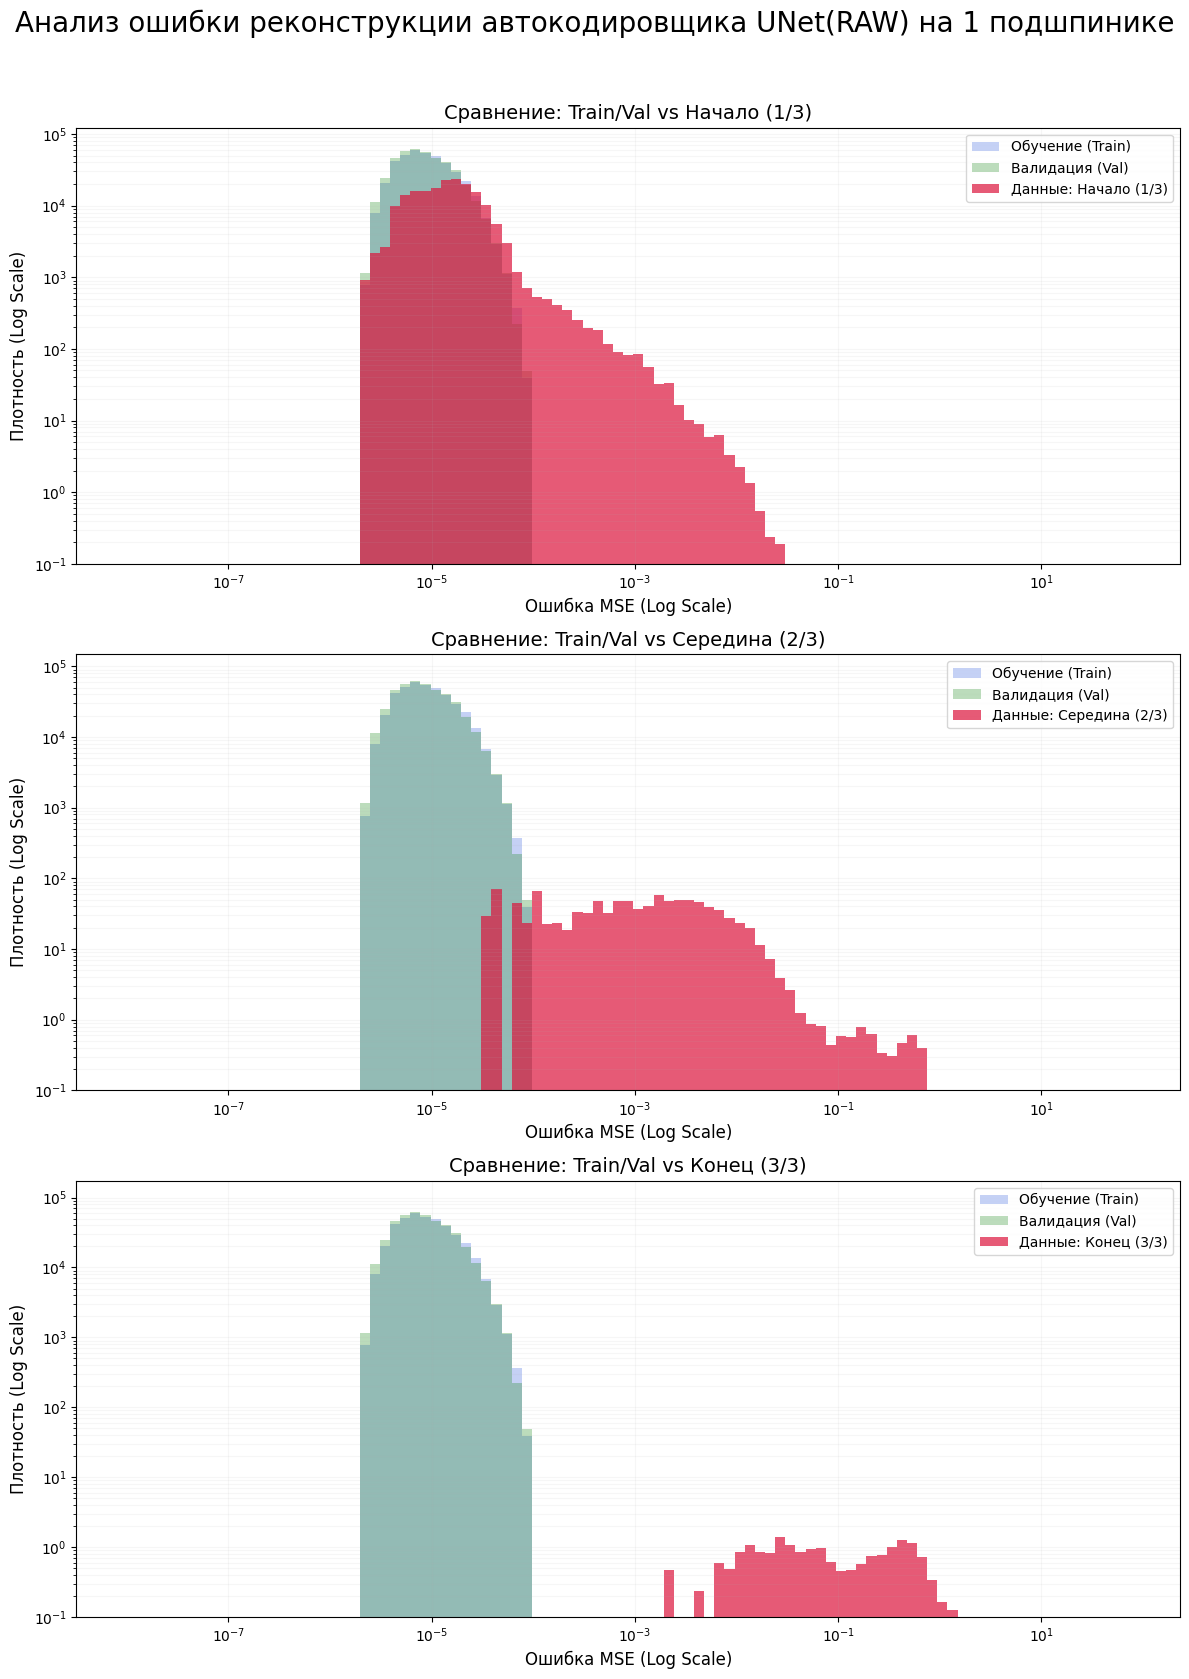

Начинаю сбор ошибок реконструкции...


1/3 Сбор Train:   0%|          | 0/30 [00:00<?, ?it/s]

2/3 Сбор Val:   0%|          | 0/21 [00:00<?, ?it/s]

3/3 Сбор Test/Bad:   0%|          | 0/50 [00:00<?, ?it/s]

Отрисовка графиков...
Готово! График сохранен: ../pictures/bearing_anomaly_report_UNet_RAW_2.png


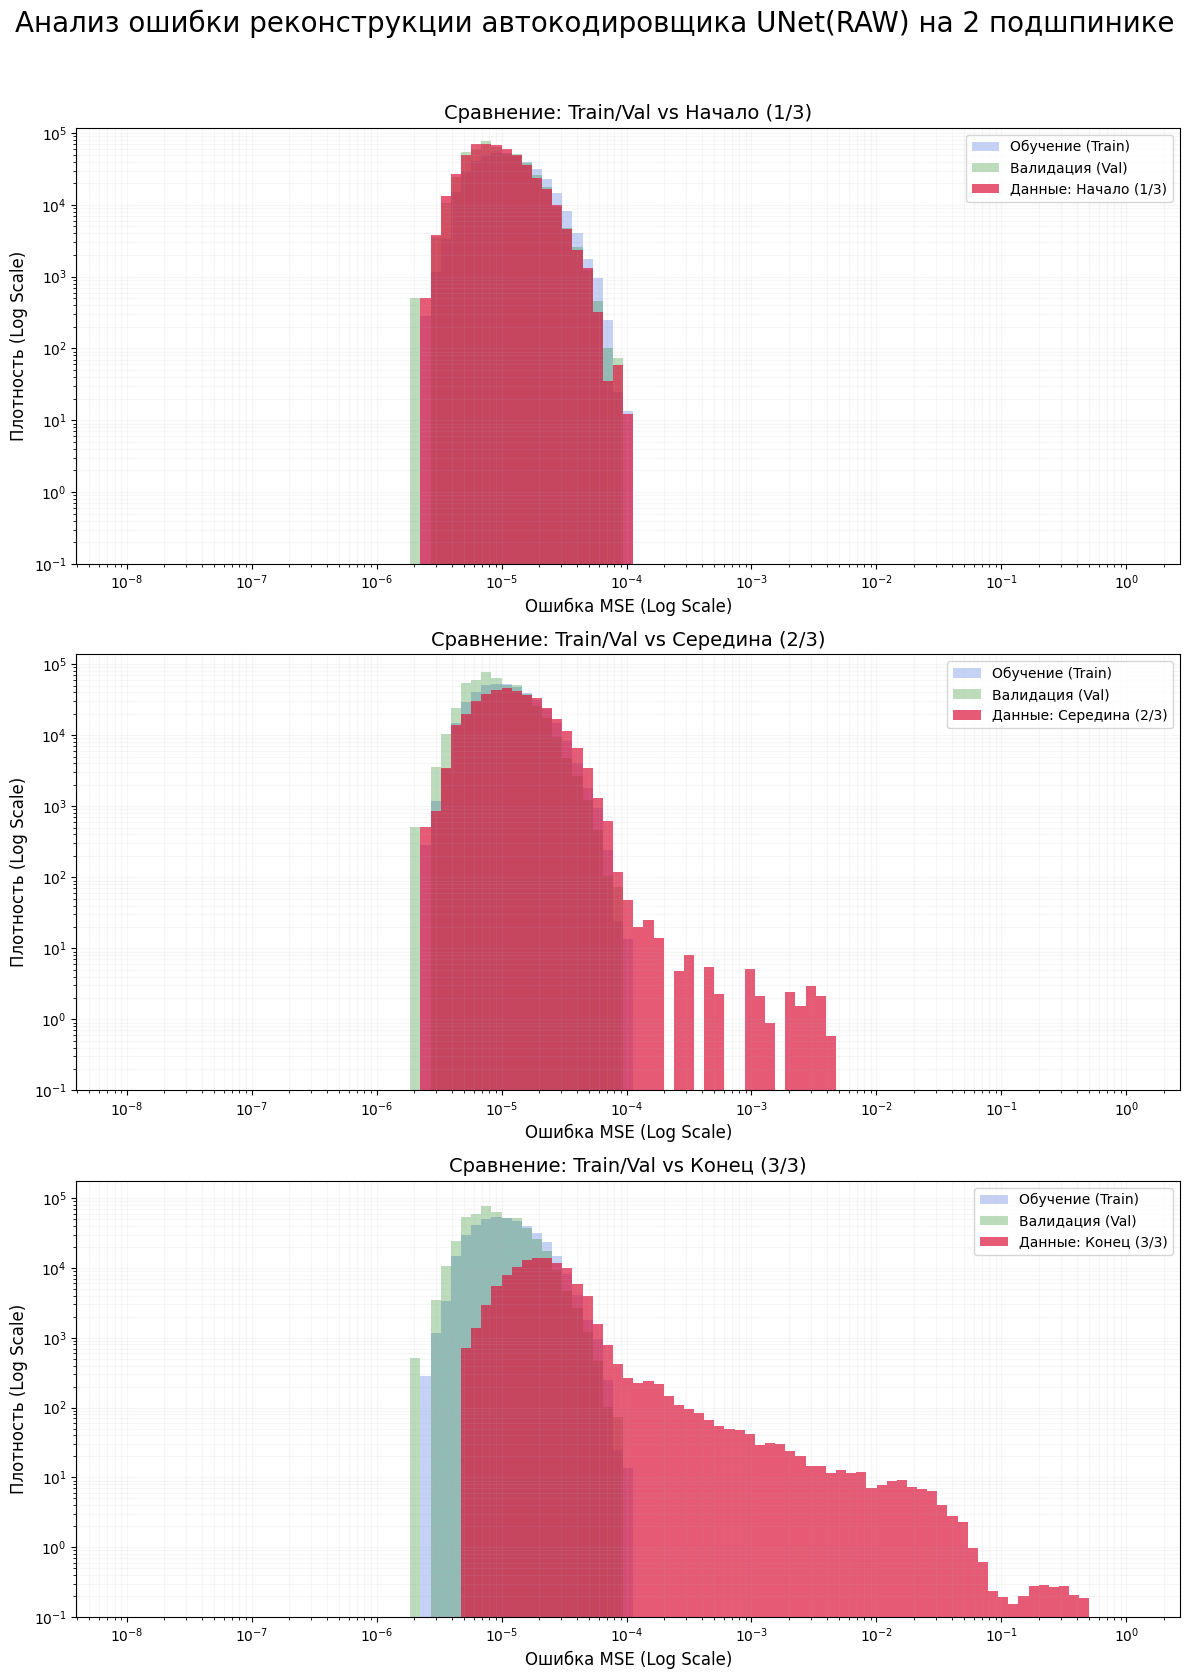

Начинаю сбор ошибок реконструкции...


1/3 Сбор Train:   0%|          | 0/30 [00:00<?, ?it/s]

2/3 Сбор Val:   0%|          | 0/21 [00:00<?, ?it/s]

3/3 Сбор Test/Bad:   0%|          | 0/50 [00:00<?, ?it/s]

Отрисовка графиков...
Готово! График сохранен: ../pictures/bearing_anomaly_report_UNet_RAW_3.png


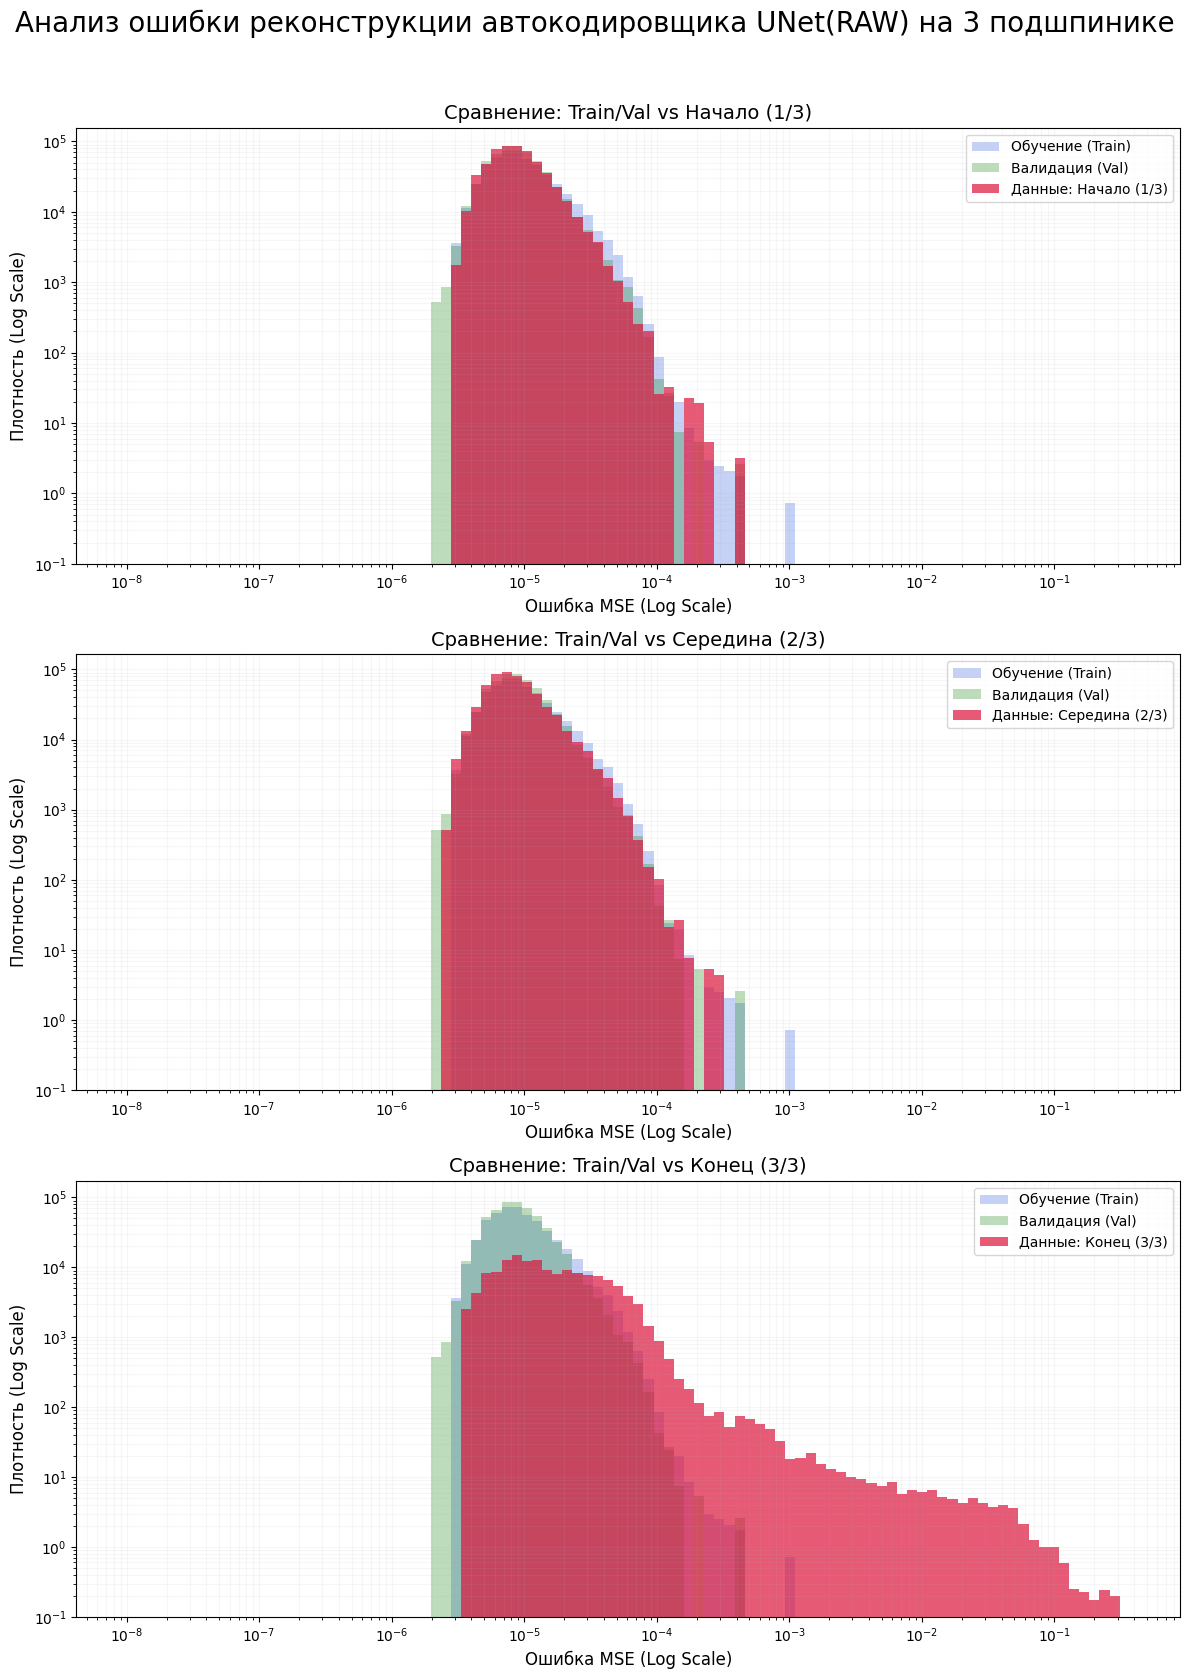

Начинаю сбор ошибок реконструкции...


1/3 Сбор Train:   0%|          | 0/30 [00:00<?, ?it/s]

2/3 Сбор Val:   0%|          | 0/21 [00:00<?, ?it/s]

3/3 Сбор Test/Bad:   0%|          | 0/50 [00:00<?, ?it/s]

Отрисовка графиков...
Готово! График сохранен: ../pictures/bearing_anomaly_report_UNet_RAW_4.png


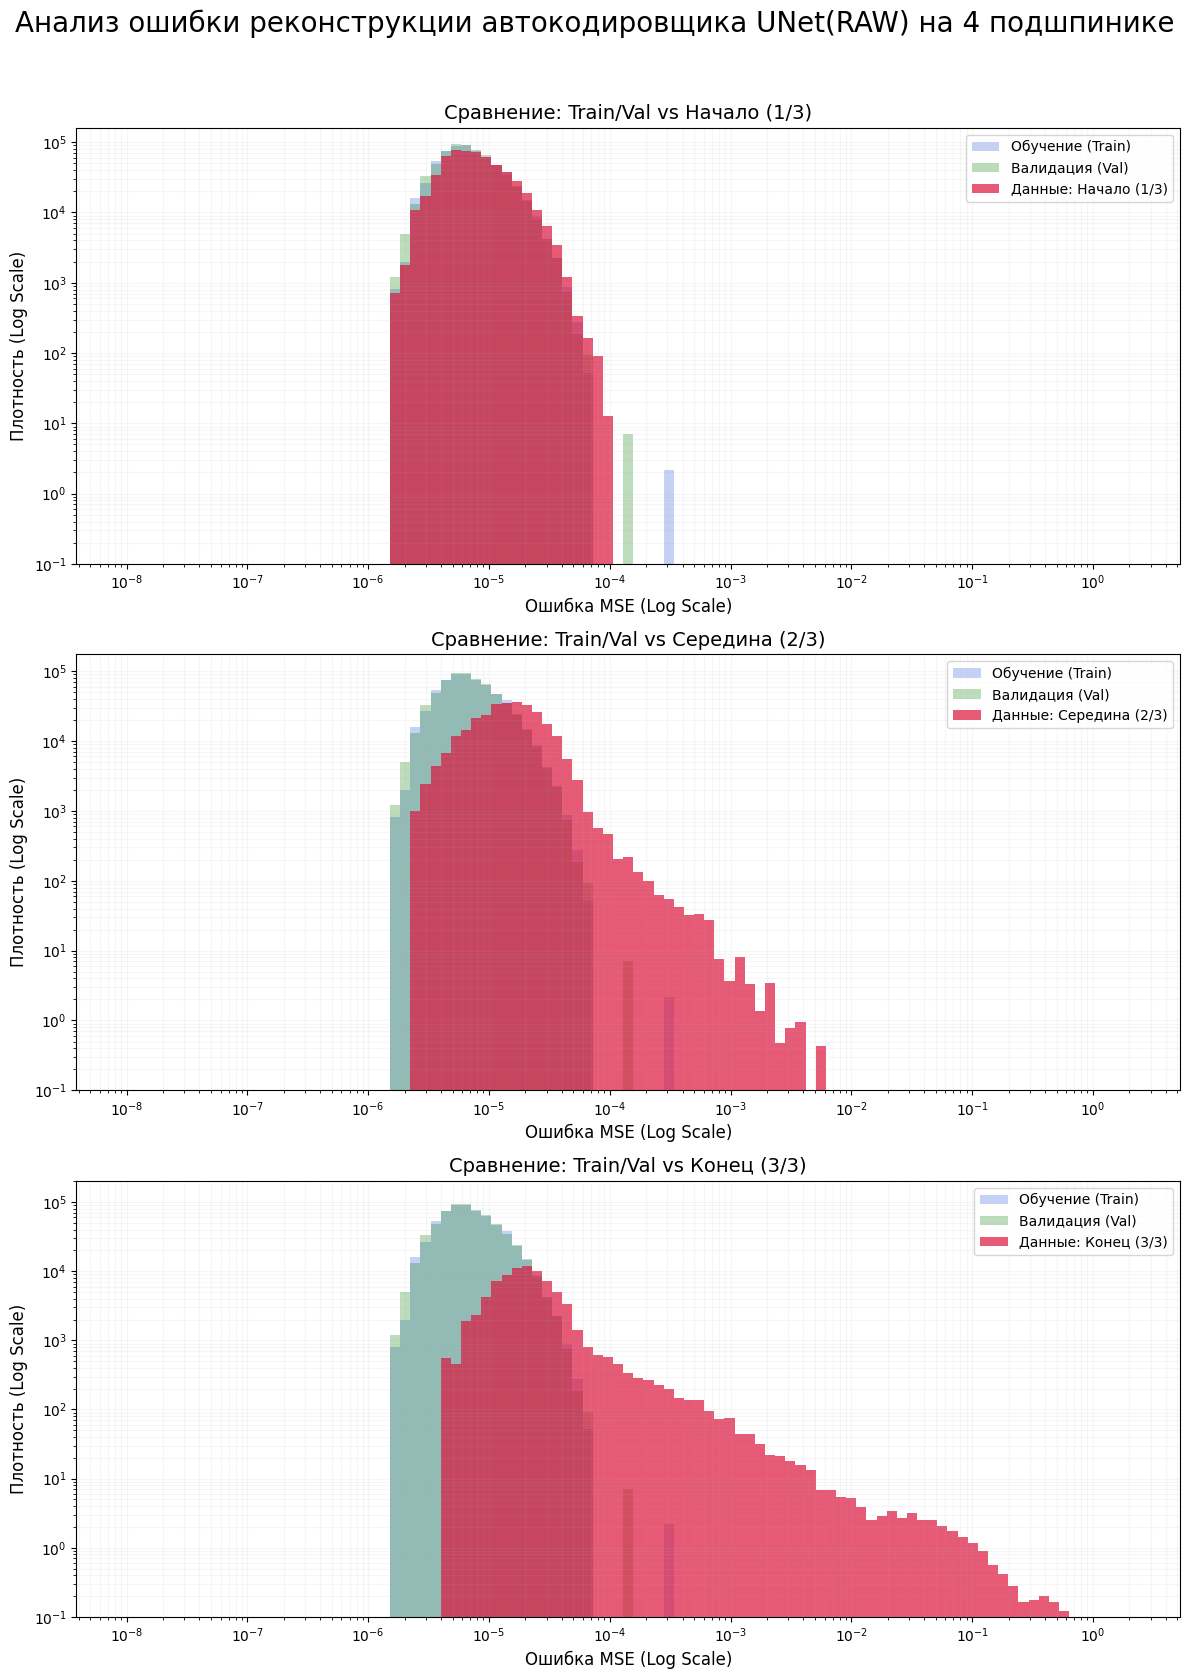

In [36]:
for i in range(4):
    train_loader = DataLoader(train_ds[i], batch_size)
    val_loader = DataLoader(val_ds[i], batch_size)
    bad_loader = DataLoader(bad_ds[i], batch_size)

    plot_ae_diagnostic(
        model=model, 
        train_loader=train_loader, 
        val_loader=val_loader, 
        test_loader=bad_loader, 
        device=device,
        save_path=f'../pictures/bearing_anomaly_report_UNet_RAW_{i+1}.png',
        main_title=f'Анализ ошибки реконструкции автокодировщика UNet(RAW) на {i+1} подшпинике'
    )

In [11]:
def get_roc_auc_progression(model, train_loader, val_loader, test_loader, device='cuda', num_parts=3):
    """
    Рассчитывает прогрессию ROC-AUC, разделяя test_loader на части.
    Возвращает Polars DataFrame с результатами.
    """
    model.eval()
    
    def collect_errors(loader, desc):
        errors = []
        with torch.no_grad():
            for batch in tqdm(loader, desc=desc, leave=False):
                x = batch[0] if isinstance(batch, (list, tuple)) else batch
                x = x.to(device)
                recon = model(x)
                # Считаем MSE на каждый объект
                mse = torch.mean((x - recon)**2, dim=tuple(range(1, x.ndim)))
                errors.extend(mse.cpu().numpy())
        return np.array(errors)

    # 1. Собираем ошибки
    print("Этап 1: Сбор ошибок реконструкции...")
    train_err = collect_errors(train_loader, "Train")
    # val_loader игнорируем, как договорились, но оставляем в аргументах
    test_err = collect_errors(test_loader, "Test")

    # 2. Делим тест на части
    test_parts = np.array_split(test_err, num_parts)
    
    results = []

    # 3. Считаем ROC-AUC для каждой части относительно Трэйна
    print(f"Этап 2: Расчет ROC-AUC для {num_parts} частей...")
    for i, part_err in enumerate(test_parts):
        # Метки: 0 для нормальных (train), 1 для текущей части теста
        y_true = np.concatenate([np.zeros(len(train_err)), np.ones(len(part_err))])
        y_scores = np.concatenate([train_err, part_err])
        
        auc = roc_auc_score(y_true, y_scores)
        
        # Дополнительно считаем во сколько раз среднее в этой части выше среднего в трейне
        mean_ratio = np.mean(part_err) / np.mean(train_err)
        
        results.append({
            "part": i + 1,
            "part_name": f"Часть {i+1}/{num_parts}",
            "samples_count": len(part_err),
            "roc_auc": float(auc),
            "mse_mean_ratio": float(mean_ratio)
        })

    # 4. Формируем Polars таблицу
    df = pl.DataFrame(results)
    
    return df

In [12]:
all_results_list = []

for i in range(4):
    print(f"\n>>> Тестирование подшипника #{i}")
    
    # Загрузка данных (ds0, ds1, ds2, ds3...)
    train_loader = DataLoader(train_ds[i], batch_size)
    val_loader = DataLoader(val_ds[i], batch_size)
    bad_loader = DataLoader(bad_ds[i], batch_size)

    # Запускаем твою функцию
    df_progression = get_roc_auc_progression(model, train_loader, val_loader, bad_loader)
    
    # Помечаем подшипник
    df_progression = df_progression.with_columns(pl.lit(f"Bearing_{i}").alias("bearing_id"))
    
    all_results_list.append(df_progression)

# 1. Объединяем всё в один большой DataFrame
full_df = pl.concat(all_results_list)

# 2. Делаем Pivot сразу по двум колонкам: roc_auc и mse_mean_ratio
top_table = full_df.pivot(
    values=["roc_auc", "mse_mean_ratio"],
    index="bearing_id",
    on="part"
)

# 3. Переименуем колонки для красоты (Polars по умолчанию назовет их типа "roc_auc_part_1")
# Можно оставить как есть или сделать короткие красивые имена:
top_table = top_table.rename({
    "roc_auc_1": "AUC_p1",
    "roc_auc_2": "AUC_p2",
    "roc_auc_3": "AUC_p3",
    "mse_mean_ratio_1": "Ratio_p1",
    "mse_mean_ratio_2": "Ratio_p2",
    "mse_mean_ratio_3": "Ratio_p3"
})

# 4. Сортируем по финальной части, чтобы аномальный подшипник был сверху
top_table = top_table.sort("AUC_p3", descending=True)

print("\nСВОДНАЯ ТАБЛИЦА МОДЕЛИ (AUC + RATIO):")
print(top_table)

# Можно сохранить в красивый CSV
# top_table.write_csv("model_final_benchmark.csv")


>>> Тестирование подшипника #0
Этап 1: Сбор ошибок реконструкции...


Train:   0%|          | 0/30 [00:00<?, ?it/s]

Test:   0%|          | 0/50 [00:00<?, ?it/s]

Этап 2: Расчет ROC-AUC для 3 частей...

>>> Тестирование подшипника #1
Этап 1: Сбор ошибок реконструкции...


Train:   0%|          | 0/30 [00:00<?, ?it/s]

Test:   0%|          | 0/50 [00:00<?, ?it/s]

Этап 2: Расчет ROC-AUC для 3 частей...

>>> Тестирование подшипника #2
Этап 1: Сбор ошибок реконструкции...


Train:   0%|          | 0/30 [00:00<?, ?it/s]

Test:   0%|          | 0/50 [00:00<?, ?it/s]

Этап 2: Расчет ROC-AUC для 3 частей...

>>> Тестирование подшипника #3
Этап 1: Сбор ошибок реконструкции...


Train:   0%|          | 0/30 [00:00<?, ?it/s]

Test:   0%|          | 0/50 [00:00<?, ?it/s]

Этап 2: Расчет ROC-AUC для 3 частей...

СВОДНАЯ ТАБЛИЦА МОДЕЛИ (AUC + RATIO):
shape: (4, 7)
┌────────────┬──────────┬──────────┬──────────┬───────────┬─────────────┬──────────────┐
│ bearing_id ┆ AUC_p1   ┆ AUC_p2   ┆ AUC_p3   ┆ Ratio_p1  ┆ Ratio_p2    ┆ Ratio_p3     │
│ ---        ┆ ---      ┆ ---      ┆ ---      ┆ ---       ┆ ---         ┆ ---          │
│ str        ┆ f64      ┆ f64      ┆ f64      ┆ f64       ┆ f64         ┆ f64          │
╞════════════╪══════════╪══════════╪══════════╪═══════════╪═════════════╪══════════════╡
│ Bearing_0  ┆ 0.782929 ┆ 0.999955 ┆ 1.0      ┆ 40.467598 ┆ 9053.039062 ┆ 161522.4375  │
│ Bearing_3  ┆ 0.55178  ┆ 0.817336 ┆ 0.960321 ┆ 1.128809  ┆ 4.311913    ┆ 10729.387695 │
│ Bearing_1  ┆ 0.403344 ┆ 0.566558 ┆ 0.89312  ┆ 0.823731  ┆ 2.168175    ┆ 2484.674561  │
│ Bearing_2  ┆ 0.434462 ┆ 0.435038 ┆ 0.871543 ┆ 0.819105  ┆ 0.850409    ┆ 1277.371216  │
└────────────┴──────────┴──────────┴──────────┴───────────┴─────────────┴──────────────┘


## Spectrum

In [13]:
from src.autoencoders.datasets import NASAIMSSpectrumDataset, get_nasa_stats
from src.autoencoders import train_loop
from src.unet1d import load_save, model

In [14]:
healthy_frac = 0.3
healthy_files = [Path(DATA_PATH) / el for el in files[:int(len(files) * healthy_frac)]]

val_frac = 0.2
val_files = [Path(DATA_PATH) / el for el in files[int(len(files) * healthy_frac) :  int(len(files) * (healthy_frac + val_frac))]]

bad_frac = 0.3
bad_files = [Path(DATA_PATH) / el for el in files[int(len(files) * (healthy_frac + val_frac)):]]


z_norm_params = get_nasa_stats(healthy_files)

ds0 = NASAIMSSpectrumDataset(healthy_files, cfg.data.window_size, cfg.data.overlap, 0, mu=z_norm_params["b1_mean"], sigma=z_norm_params["b1_std"])
ds1 = NASAIMSSpectrumDataset(healthy_files, cfg.data.window_size, cfg.data.overlap, 1, mu=z_norm_params["b2_mean"], sigma=z_norm_params["b2_std"])
ds2 = NASAIMSSpectrumDataset(healthy_files, cfg.data.window_size, cfg.data.overlap, 2, mu=z_norm_params["b3_mean"], sigma=z_norm_params["b3_std"])
ds3 = NASAIMSSpectrumDataset(healthy_files, cfg.data.window_size, cfg.data.overlap, 3, mu=z_norm_params["b4_mean"], sigma=z_norm_params["b4_std"])

val_ds0 = NASAIMSSpectrumDataset(val_files, cfg.data.window_size, cfg.data.overlap, 0, mu=z_norm_params["b1_mean"], sigma=z_norm_params["b1_std"])
val_ds1 = NASAIMSSpectrumDataset(val_files, cfg.data.window_size, cfg.data.overlap, 1, mu=z_norm_params["b2_mean"], sigma=z_norm_params["b2_std"])
val_ds2 = NASAIMSSpectrumDataset(val_files, cfg.data.window_size, cfg.data.overlap, 2, mu=z_norm_params["b3_mean"], sigma=z_norm_params["b3_std"])
val_ds3 = NASAIMSSpectrumDataset(val_files, cfg.data.window_size, cfg.data.overlap, 3, mu=z_norm_params["b4_mean"], sigma=z_norm_params["b4_std"])

bad_ds0 = NASAIMSSpectrumDataset(bad_files, cfg.data.window_size, cfg.data.overlap, 0, mu=z_norm_params["b1_mean"], sigma=z_norm_params["b1_std"])
bad_ds1 = NASAIMSSpectrumDataset(bad_files, cfg.data.window_size, cfg.data.overlap, 1, mu=z_norm_params["b2_mean"], sigma=z_norm_params["b2_std"])
bad_ds2 = NASAIMSSpectrumDataset(bad_files, cfg.data.window_size, cfg.data.overlap, 2, mu=z_norm_params["b3_mean"], sigma=z_norm_params["b3_std"])
bad_ds3 = NASAIMSSpectrumDataset(bad_files, cfg.data.window_size, cfg.data.overlap, 3, mu=z_norm_params["b4_mean"], sigma=z_norm_params["b4_std"])



Reading files:   0%|          | 0/295 [00:00<?, ?it/s]

Loading 295 files into memory...


  0%|          | 0/295 [00:00<?, ?it/s]

Spectrum Dataset ready. Total windows: 7670
Loading 295 files into memory...


  0%|          | 0/295 [00:00<?, ?it/s]

Spectrum Dataset ready. Total windows: 7670
Loading 295 files into memory...


  0%|          | 0/295 [00:00<?, ?it/s]

Spectrum Dataset ready. Total windows: 7670
Loading 295 files into memory...


  0%|          | 0/295 [00:00<?, ?it/s]

Spectrum Dataset ready. Total windows: 7670
Loading 197 files into memory...


  0%|          | 0/197 [00:00<?, ?it/s]

Spectrum Dataset ready. Total windows: 5122
Loading 197 files into memory...


  0%|          | 0/197 [00:00<?, ?it/s]

Spectrum Dataset ready. Total windows: 5122
Loading 197 files into memory...


  0%|          | 0/197 [00:00<?, ?it/s]

Spectrum Dataset ready. Total windows: 5122
Loading 197 files into memory...


  0%|          | 0/197 [00:00<?, ?it/s]

Spectrum Dataset ready. Total windows: 5122
Loading 492 files into memory...


  0%|          | 0/492 [00:00<?, ?it/s]

Spectrum Dataset ready. Total windows: 12792
Loading 492 files into memory...


  0%|          | 0/492 [00:00<?, ?it/s]

Spectrum Dataset ready. Total windows: 12792
Loading 492 files into memory...


  0%|          | 0/492 [00:00<?, ?it/s]

Spectrum Dataset ready. Total windows: 12792
Loading 492 files into memory...


  0%|          | 0/492 [00:00<?, ?it/s]

Spectrum Dataset ready. Total windows: 12792


In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [16]:
model, metadata = load_save.load_model_checkpoint("../ae_checkpoints/ae_model_spectrum_epoch6.pth", device=device)

/home/mihalko711/some_code/MFMLD/src/unet1d/load_save.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=device)


In [17]:
batch_size = 256

train_ds = [ds0, ds1, ds2, ds3]
val_ds = [val_ds0, val_ds1, val_ds2, val_ds3]
bad_ds = [bad_ds0, bad_ds1, bad_ds2, bad_ds3]

In [51]:
def get_roc_auc_progression(model, train_loader, val_loader, test_loader, device='cuda', num_parts=3):
    """
    Рассчитывает прогрессию ROC-AUC, разделяя test_loader на части.
    Возвращает Polars DataFrame с результатами.
    """
    model.eval()
    
    def collect_errors(loader, desc):
        errors = []
        with torch.no_grad():
            for batch in tqdm(loader, desc=desc, leave=False):
                x = batch[0] if isinstance(batch, (list, tuple)) else batch
                x = x.to(device)
                recon = model(x)
                # Считаем MSE на каждый объект
                mse = torch.mean((x - recon)**2, dim=tuple(range(1, x.ndim)))
                errors.extend(mse.cpu().numpy())
        return np.array(errors)

    # 1. Собираем ошибки
    print("Этап 1: Сбор ошибок реконструкции...")
    train_err = collect_errors(train_loader, "Train")
    # val_loader игнорируем, как договорились, но оставляем в аргументах
    test_err = collect_errors(test_loader, "Test")

    # 2. Делим тест на части
    test_parts = np.array_split(test_err, num_parts)
    
    results = []

    # 3. Считаем ROC-AUC для каждой части относительно Трэйна
    print(f"Этап 2: Расчет ROC-AUC для {num_parts} частей...")
    for i, part_err in enumerate(test_parts):
        # Метки: 0 для нормальных (train), 1 для текущей части теста
        y_true = np.concatenate([np.zeros(len(train_err)), np.ones(len(part_err))])
        y_scores = np.concatenate([train_err, part_err])
        
        auc = roc_auc_score(y_true, y_scores)
        
        # Дополнительно считаем во сколько раз среднее в этой части выше среднего в трейне
        mean_ratio = np.mean(part_err) / np.mean(train_err)
        
        results.append({
            "part": i + 1,
            "part_name": f"Часть {i+1}/{num_parts}",
            "samples_count": len(part_err),
            "roc_auc": float(auc),
            "mse_mean_ratio": float(mean_ratio)
        })

    # 4. Формируем Polars таблицу
    df = pl.DataFrame(results)
    
    return df

In [18]:
all_results_list = []

for i in range(4):
    print(f"\n>>> Тестирование подшипника #{i}")
    
    # Загрузка данных (ds0, ds1, ds2, ds3...)
    train_loader = DataLoader(train_ds[i], batch_size)
    val_loader = DataLoader(val_ds[i], batch_size)
    bad_loader = DataLoader(bad_ds[i], batch_size)

    # Запускаем твою функцию
    df_progression = get_roc_auc_progression(model, train_loader, val_loader, bad_loader)
    
    # Помечаем подшипник
    df_progression = df_progression.with_columns(pl.lit(f"Bearing_{i}").alias("bearing_id"))
    
    all_results_list.append(df_progression)

# 1. Объединяем всё в один большой DataFrame
full_df = pl.concat(all_results_list)

# 2. Делаем Pivot сразу по двум колонкам: roc_auc и mse_mean_ratio
top_table = full_df.pivot(
    values=["roc_auc", "mse_mean_ratio"],
    index="bearing_id",
    on="part"
)

# 3. Переименуем колонки для красоты (Polars по умолчанию назовет их типа "roc_auc_part_1")
# Можно оставить как есть или сделать короткие красивые имена:
top_table = top_table.rename({
    "roc_auc_1": "AUC_p1",
    "roc_auc_2": "AUC_p2",
    "roc_auc_3": "AUC_p3",
    "mse_mean_ratio_1": "Ratio_p1",
    "mse_mean_ratio_2": "Ratio_p2",
    "mse_mean_ratio_3": "Ratio_p3"
})

# 4. Сортируем по финальной части, чтобы аномальный подшипник был сверху
top_table = top_table.sort("AUC_p3", descending=True)

print("\nСВОДНАЯ ТАБЛИЦА МОДЕЛИ (AUC + RATIO):")
print(top_table)

# Можно сохранить в красивый CSV
# top_table.write_csv("model_final_benchmark.csv")


>>> Тестирование подшипника #0
Этап 1: Сбор ошибок реконструкции...


Train:   0%|          | 0/30 [00:00<?, ?it/s]

Test:   0%|          | 0/50 [00:00<?, ?it/s]

Этап 2: Расчет ROC-AUC для 3 частей...

>>> Тестирование подшипника #1
Этап 1: Сбор ошибок реконструкции...


Train:   0%|          | 0/30 [00:00<?, ?it/s]

Test:   0%|          | 0/50 [00:00<?, ?it/s]

Этап 2: Расчет ROC-AUC для 3 частей...

>>> Тестирование подшипника #2
Этап 1: Сбор ошибок реконструкции...


Train:   0%|          | 0/30 [00:00<?, ?it/s]

Test:   0%|          | 0/50 [00:00<?, ?it/s]

Этап 2: Расчет ROC-AUC для 3 частей...

>>> Тестирование подшипника #3
Этап 1: Сбор ошибок реконструкции...


Train:   0%|          | 0/30 [00:00<?, ?it/s]

Test:   0%|          | 0/50 [00:00<?, ?it/s]

Этап 2: Расчет ROC-AUC для 3 частей...

СВОДНАЯ ТАБЛИЦА МОДЕЛИ (AUC + RATIO):
shape: (4, 7)
┌────────────┬──────────┬──────────┬──────────┬──────────┬───────────┬─────────────┐
│ bearing_id ┆ AUC_p1   ┆ AUC_p2   ┆ AUC_p3   ┆ Ratio_p1 ┆ Ratio_p2  ┆ Ratio_p3    │
│ ---        ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---       ┆ ---         │
│ str        ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64       ┆ f64         │
╞════════════╪══════════╪══════════╪══════════╪══════════╪═══════════╪═════════════╡
│ Bearing_0  ┆ 0.419625 ┆ 0.599608 ┆ 0.986081 ┆ 0.864492 ┆ 43.950275 ┆ 6010.768066 │
│ Bearing_3  ┆ 0.496631 ┆ 0.411189 ┆ 0.462437 ┆ 0.986095 ┆ 0.880161  ┆ 793.443542  │
│ Bearing_1  ┆ 0.482445 ┆ 0.472957 ┆ 0.391085 ┆ 0.942914 ┆ 0.948326  ┆ 416.583008  │
│ Bearing_2  ┆ 0.44239  ┆ 0.426854 ┆ 0.289631 ┆ 0.809845 ┆ 0.742446  ┆ 164.178467  │
└────────────┴──────────┴──────────┴──────────┴──────────┴───────────┴─────────────┘


## Mel

In [35]:
from hydra import initialize, compose
from omegaconf import OmegaConf

with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name="config_mel")
    print(cfg)

{'data': {'window_size': 1024, 'overlap': 768, 'spectral': False, 'sample_rate': 20000, 'f_max': 5000, 'n_mels': 64, 'chunk_size': 8192, 'chunk_overlap': 6144}}


In [36]:
from src.autoencoders.datasets import NASAIMSMelDataset, get_nasa_stats
from src.autoencoders import train_loop2d
from src.unet2d import load_save, model

In [37]:
healthy_frac = 0.3
healthy_files = [Path(DATA_PATH) / el for el in files[:int(len(files) * healthy_frac)]]

val_frac = 0.2
val_files = [Path(DATA_PATH) / el for el in files[int(len(files) * healthy_frac) :  int(len(files) * (healthy_frac + val_frac))]]

bad_frac = 0.3
bad_files = [Path(DATA_PATH) / el for el in files[int(len(files) * (healthy_frac + val_frac)):]]


z_norm_params = get_nasa_stats(healthy_files)

ds0 = NASAIMSMelDataset(healthy_files, 0, 
                        cfg.data.sample_rate, cfg.data.chunk_size,
                        cfg.data.chunk_overlap, cfg.data.window_size, 
                        cfg.data.window_size - cfg.data.overlap,
                        cfg.data.n_mels, cfg.data.f_max,
                        z_norm_params["b1_mean"][0], z_norm_params["b1_std"][0]
                       )
ds1 = NASAIMSMelDataset(healthy_files, 1, 
                        cfg.data.sample_rate, cfg.data.chunk_size,
                        cfg.data.chunk_overlap, cfg.data.window_size, 
                        cfg.data.window_size - cfg.data.overlap,
                        cfg.data.n_mels, cfg.data.f_max,
                        z_norm_params["b2_mean"][0], z_norm_params["b2_std"][0]
                       )
ds2 = NASAIMSMelDataset(healthy_files, 2, 
                        cfg.data.sample_rate, cfg.data.chunk_size,
                        cfg.data.chunk_overlap, cfg.data.window_size, 
                        cfg.data.window_size - cfg.data.overlap,
                        cfg.data.n_mels, cfg.data.f_max,
                        z_norm_params["b3_mean"][0], z_norm_params["b3_std"][0]
                       )
ds3 = NASAIMSMelDataset(healthy_files, 3, 
                        cfg.data.sample_rate, cfg.data.chunk_size,
                        cfg.data.chunk_overlap, cfg.data.window_size, 
                        cfg.data.window_size - cfg.data.overlap,
                        cfg.data.n_mels, cfg.data.f_max,
                        z_norm_params["b4_mean"][0], z_norm_params["b4_std"][0]
                       )

val_ds0 = NASAIMSMelDataset(val_files, 0, 
                        cfg.data.sample_rate, cfg.data.chunk_size,
                        cfg.data.chunk_overlap, cfg.data.window_size, 
                        cfg.data.window_size - cfg.data.overlap,
                        cfg.data.n_mels, cfg.data.f_max,
                        z_norm_params["b1_mean"][0], z_norm_params["b1_std"][0]
                       )
val_ds1 = NASAIMSMelDataset(val_files, 1, 
                        cfg.data.sample_rate, cfg.data.chunk_size,
                        cfg.data.chunk_overlap, cfg.data.window_size, 
                        cfg.data.window_size - cfg.data.overlap,
                        cfg.data.n_mels, cfg.data.f_max,
                        z_norm_params["b2_mean"][0], z_norm_params["b2_std"][0]
                       )
val_ds2 = NASAIMSMelDataset(val_files, 2, 
                        cfg.data.sample_rate, cfg.data.chunk_size,
                        cfg.data.chunk_overlap, cfg.data.window_size, 
                        cfg.data.window_size - cfg.data.overlap,
                        cfg.data.n_mels, cfg.data.f_max,
                        z_norm_params["b3_mean"][0], z_norm_params["b3_std"][0]
                       )
val_ds3 = NASAIMSMelDataset(val_files, 3, 
                        cfg.data.sample_rate, cfg.data.chunk_size,
                        cfg.data.chunk_overlap, cfg.data.window_size, 
                        cfg.data.window_size - cfg.data.overlap,
                        cfg.data.n_mels, cfg.data.f_max,
                        z_norm_params["b4_mean"][0], z_norm_params["b4_std"][0]
                       )
bad_ds0 = NASAIMSMelDataset(bad_files, 0, 
                        cfg.data.sample_rate, cfg.data.chunk_size,
                        cfg.data.chunk_overlap, cfg.data.window_size, 
                        cfg.data.window_size - cfg.data.overlap,
                        cfg.data.n_mels, cfg.data.f_max,
                        z_norm_params["b1_mean"][0], z_norm_params["b1_std"][0]
                       )
bad_ds1 = NASAIMSMelDataset(bad_files, 1, 
                        cfg.data.sample_rate, cfg.data.chunk_size,
                        cfg.data.chunk_overlap, cfg.data.window_size, 
                        cfg.data.window_size - cfg.data.overlap,
                        cfg.data.n_mels, cfg.data.f_max,
                        z_norm_params["b2_mean"][0], z_norm_params["b2_std"][0]
                       )
bad_ds2 = NASAIMSMelDataset(bad_files, 2, 
                        cfg.data.sample_rate, cfg.data.chunk_size,
                        cfg.data.chunk_overlap, cfg.data.window_size, 
                        cfg.data.window_size - cfg.data.overlap,
                        cfg.data.n_mels, cfg.data.f_max,
                        z_norm_params["b3_mean"][0], z_norm_params["b3_std"][0]
                       )
bad_ds3 = NASAIMSMelDataset(bad_files, 3, 
                        cfg.data.sample_rate, cfg.data.chunk_size,
                        cfg.data.chunk_overlap, cfg.data.window_size, 
                        cfg.data.window_size - cfg.data.overlap,
                        cfg.data.n_mels, cfg.data.f_max,
                        z_norm_params["b4_mean"][0], z_norm_params["b4_std"][0]
                       )



Reading files:   0%|          | 0/295 [00:00<?, ?it/s]

Dataset: 295 files.
Chunks per file: 7, Total samples: 2065
Dataset: 295 files.
Chunks per file: 7, Total samples: 2065
Dataset: 295 files.
Chunks per file: 7, Total samples: 2065
Dataset: 295 files.
Chunks per file: 7, Total samples: 2065
Dataset: 197 files.
Chunks per file: 7, Total samples: 1379
Dataset: 197 files.
Chunks per file: 7, Total samples: 1379
Dataset: 197 files.
Chunks per file: 7, Total samples: 1379
Dataset: 197 files.
Chunks per file: 7, Total samples: 1379
Dataset: 492 files.
Chunks per file: 7, Total samples: 3444
Dataset: 492 files.
Chunks per file: 7, Total samples: 3444
Dataset: 492 files.
Chunks per file: 7, Total samples: 3444
Dataset: 492 files.
Chunks per file: 7, Total samples: 3444


In [38]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [39]:
model, metadata = load_save.load_model_checkpoint("../ae_checkpoints/ae_model_mel_epoch14.pth", device=device)

/home/mihalko711/some_code/MFMLD/src/unet2d/load_save.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=device)


In [40]:
batch_size = 256

train_ds = [ds0, ds1, ds2, ds3]
val_ds = [val_ds0, val_ds1, val_ds2, val_ds3]
bad_ds = [bad_ds0, bad_ds1, bad_ds2, bad_ds3]

In [69]:
def get_roc_auc_progression(model, train_loader, val_loader, test_loader, device='cuda', num_parts=3):
    """
    Рассчитывает прогрессию ROC-AUC, разделяя test_loader на части.
    Возвращает Polars DataFrame с результатами.
    """
    model.eval()
    
    def collect_errors(loader, desc):
        errors = []
        with torch.no_grad():
            for batch in tqdm(loader, desc=desc, leave=False):
                x = batch[0] if isinstance(batch, (list, tuple)) else batch
                x = x.to(device)
                recon = model(x)
                # Считаем MSE на каждый объект
                mse = torch.mean((x - recon)**2, dim=tuple(range(1, x.ndim)))
                errors.extend(mse.cpu().numpy())
        return np.array(errors)

    # 1. Собираем ошибки
    print("Этап 1: Сбор ошибок реконструкции...")
    train_err = collect_errors(train_loader, "Train")
    # val_loader игнорируем, как договорились, но оставляем в аргументах
    test_err = collect_errors(test_loader, "Test")

    # 2. Делим тест на части
    test_parts = np.array_split(test_err, num_parts)
    
    results = []

    # 3. Считаем ROC-AUC для каждой части относительно Трэйна
    print(f"Этап 2: Расчет ROC-AUC для {num_parts} частей...")
    for i, part_err in enumerate(test_parts):
        # Метки: 0 для нормальных (train), 1 для текущей части теста
        y_true = np.concatenate([np.zeros(len(train_err)), np.ones(len(part_err))])
        y_scores = np.concatenate([train_err, part_err])
        
        auc = roc_auc_score(y_true, y_scores)
        
        # Дополнительно считаем во сколько раз среднее в этой части выше среднего в трейне
        mean_ratio = np.mean(part_err) / np.mean(train_err)
        
        results.append({
            "part": i + 1,
            "part_name": f"Часть {i+1}/{num_parts}",
            "samples_count": len(part_err),
            "roc_auc": float(auc),
            "mse_mean_ratio": float(mean_ratio)
        })

    # 4. Формируем Polars таблицу
    df = pl.DataFrame(results)
    
    return df

In [73]:
all_results_list = []

for i in range(4):
    print(f"\n>>> Тестирование подшипника #{i}")
    
    # Загрузка данных (ds0, ds1, ds2, ds3...)
    train_loader = DataLoader(train_ds[i], batch_size)
    val_loader = DataLoader(val_ds[i], batch_size)
    bad_loader = DataLoader(bad_ds[i], batch_size)

    # Запускаем твою функцию
    df_progression = get_roc_auc_progression(model, train_loader, val_loader, bad_loader)
    
    # Помечаем подшипник
    df_progression = df_progression.with_columns(pl.lit(f"Bearing_{i}").alias("bearing_id"))
    
    all_results_list.append(df_progression)

# 1. Объединяем всё в один большой DataFrame
full_df = pl.concat(all_results_list)

# 2. Делаем Pivot сразу по двум колонкам: roc_auc и mse_mean_ratio
top_table = full_df.pivot(
    values=["roc_auc", "mse_mean_ratio"],
    index="bearing_id",
    on="part"
)

# 3. Переименуем колонки для красоты (Polars по умолчанию назовет их типа "roc_auc_part_1")
# Можно оставить как есть или сделать короткие красивые имена:
top_table = top_table.rename({
    "roc_auc_1": "AUC_p1",
    "roc_auc_2": "AUC_p2",
    "roc_auc_3": "AUC_p3",
    "mse_mean_ratio_1": "Ratio_p1",
    "mse_mean_ratio_2": "Ratio_p2",
    "mse_mean_ratio_3": "Ratio_p3"
})

# 4. Сортируем по финальной части, чтобы аномальный подшипник был сверху
top_table = top_table.sort("AUC_p3", descending=True)

print("\nСВОДНАЯ ТАБЛИЦА МОДЕЛИ (AUC + RATIO):")
print(top_table)

# Можно сохранить в красивый CSV
# top_table.write_csv("model_final_benchmark.csv")


>>> Тестирование подшипника #0
Этап 1: Сбор ошибок реконструкции...


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/14 [00:00<?, ?it/s]

Этап 2: Расчет ROC-AUC для 3 частей...

>>> Тестирование подшипника #1
Этап 1: Сбор ошибок реконструкции...


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/14 [00:00<?, ?it/s]

Этап 2: Расчет ROC-AUC для 3 частей...

>>> Тестирование подшипника #2
Этап 1: Сбор ошибок реконструкции...


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/14 [00:00<?, ?it/s]

Этап 2: Расчет ROC-AUC для 3 частей...

>>> Тестирование подшипника #3
Этап 1: Сбор ошибок реконструкции...


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/14 [00:00<?, ?it/s]

Этап 2: Расчет ROC-AUC для 3 частей...

СВОДНАЯ ТАБЛИЦА МОДЕЛИ (AUC + RATIO):
shape: (4, 7)
┌────────────┬──────────┬──────────┬──────────┬──────────┬──────────┬────────────┐
│ bearing_id ┆ AUC_p1   ┆ AUC_p2   ┆ AUC_p3   ┆ Ratio_p1 ┆ Ratio_p2 ┆ Ratio_p3   │
│ ---        ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---        │
│ str        ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64        │
╞════════════╪══════════╪══════════╪══════════╪══════════╪══════════╪════════════╡
│ Bearing_0  ┆ 0.906688 ┆ 1.0      ┆ 1.0      ┆ 6.837863 ┆ 53.71833 ┆ 386.315002 │
│ Bearing_3  ┆ 0.638859 ┆ 0.980452 ┆ 1.0      ┆ 1.273865 ┆ 7.539536 ┆ 60.504414  │
│ Bearing_1  ┆ 0.339012 ┆ 0.81735  ┆ 0.998999 ┆ 0.824974 ┆ 2.45996  ┆ 34.156841  │
│ Bearing_2  ┆ 0.489611 ┆ 0.518117 ┆ 0.937624 ┆ 0.951325 ┆ 0.985509 ┆ 14.455303  │
└────────────┴──────────┴──────────┴──────────┴──────────┴──────────┴────────────┘


### Пример реконструкции спектрограммы в каждой части

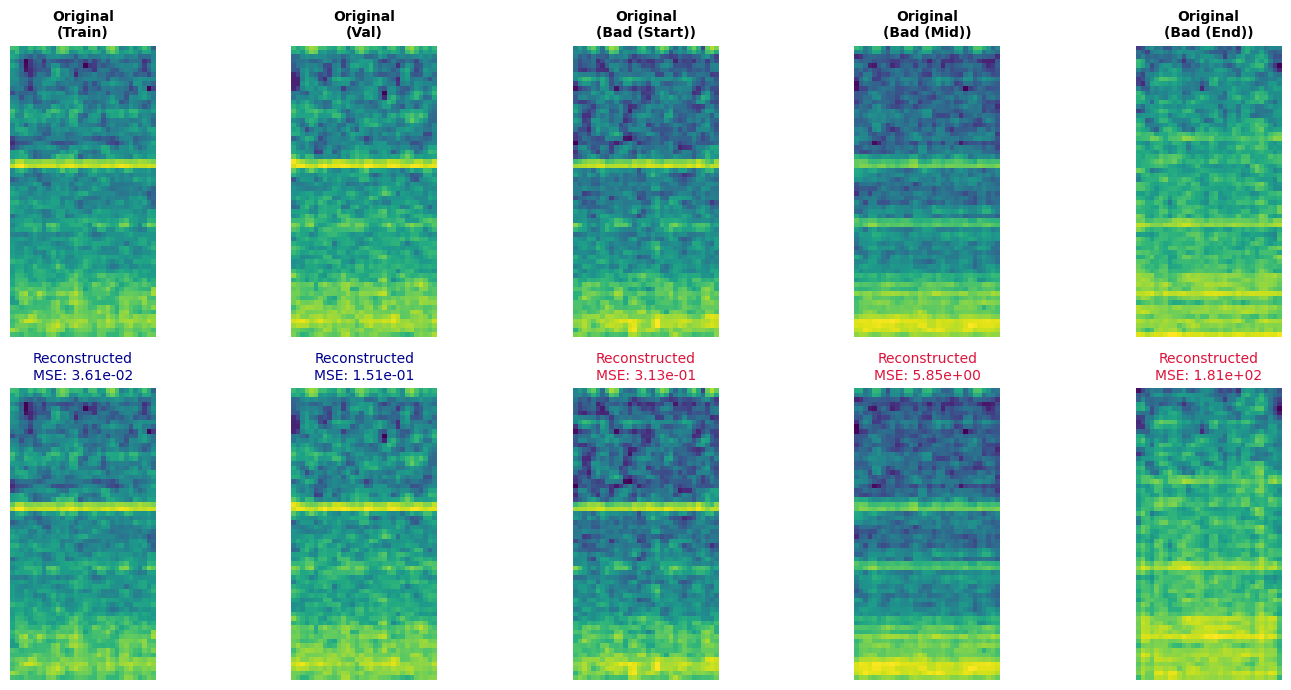

In [53]:
len_bad = len(bad_ds0)
idx_train = np.random.randint(len(ds0))
idx_val = np.random.randint(len(val_ds0))
idx_bad_1 = np.random.randint(0, int(1/3 * len_bad))
idx_bad_2 = np.random.randint(int(1/3 * len_bad), int(2/3 * len_bad))
idx_bad_3 = np.random.randint(int(2/3 * len_bad), len_bad)

labels = ["Train", "Val", "Bad (Start)", "Bad (Mid)", "Bad (End)"]
specgrams = torch.stack([ds0[idx_train], val_ds0[idx_val], bad_ds0[idx_bad_1], bad_ds0[idx_bad_2], bad_ds0[idx_bad_3]])

# 2. Прогон через модель
model.eval()
with torch.no_grad():
    inputs = specgrams.to(device)
    outputs = model(inputs)
    rec_specgrams = outputs.cpu()

# 3. Расчет MSE для каждого из 5 примеров
# Считаем MSE по осям (C, H, W) -> получаем 5 чисел
mses = torch.mean((specgrams - rec_specgrams)**2, dim=(1, 2, 3)).numpy()

# 4. Визуализация
fig, ax = plt.subplots(2, 5, figsize=(15, 7), facecolor='white')

for i in range(5):
    # Верхний ряд: Оригиналы
    img_orig = specgrams[i].permute(1, 2, 0).numpy()
    # Если данные в диапазоне [-1, 1], нормализуем для imshow
    img_orig = (img_orig - img_orig.min()) / (img_orig.max() - img_orig.min() + 1e-8)
    
    ax[0][i].imshow(img_orig)
    ax[0][i].set_title(f"Original\n({labels[i]})", fontsize=10, fontweight='bold')
    ax[0][i].axis('off') # Отключаем оси

    # Нижний ряд: Реконструкции
    img_rec = rec_specgrams[i].permute(1, 2, 0).numpy()
    img_rec = (img_rec - img_rec.min()) / (img_rec.max() - img_rec.min() + 1e-8)
    
    ax[1][i].imshow(img_rec)
    # Добавляем подпись с типом и конкретной ошибкой
    ax[1][i].set_title(f"Reconstructed\nMSE: {mses[i]:.2e}", fontsize=10, color='crimson' if i >= 2 else 'darkblue')
    ax[1][i].axis('off') # Отключаем оси

plt.tight_layout()

# 5. Сохранение
plt.savefig("../pictures/reconstruction_samples_with_mse.png", dpi=150, bbox_inches='tight')
plt.show()

In [49]:
rec_specgrams.shape

torch.Size([5, 1, 64, 32])

# FC

## Spectrum

In [19]:
from hydra import initialize, compose
from omegaconf import OmegaConf

with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name="config")
    print(cfg)

{'data': {'window_size': 1024, 'overlap': 256, 'spectral': False, 'sample_rate': 20000, 'f_max': 5000, 'n_mels': 64, 'chunk_size': 8192, 'chunk_overlap': 6144}}


In [20]:
from src.forecasters.datasets import NASAIMSLongTermSpectrumDataset, get_nasa_stats
from torch.utils.data import ConcatDataset
from src.unet1d import model, load_save
from src.forecasters import train_loop

In [21]:
healthy_frac = 0.3
healthy_files = [Path(DATA_PATH) / el for el in files[:int(len(files) * healthy_frac)]]

val_frac = 0.2
val_files = [Path(DATA_PATH) / el for el in files[int(len(files) * healthy_frac) :  int(len(files) * (healthy_frac + val_frac))]]

bad_frac = 0.3
bad_files = [Path(DATA_PATH) / el for el in files[int(len(files) * (healthy_frac + val_frac)):]]


z_norm_params = get_nasa_stats(healthy_files)
horizon_files = 1

ds0 = NASAIMSLongTermSpectrumDataset(healthy_files, cfg.data.window_size,
                             cfg.data.window_size - cfg.data.overlap,
                             horizon_files, 0, mu=z_norm_params["b1_mean"], sigma=z_norm_params["b1_std"])
ds1 = NASAIMSLongTermSpectrumDataset(healthy_files, cfg.data.window_size,
                             cfg.data.window_size - cfg.data.overlap,
                             horizon_files, 1, mu=z_norm_params["b2_mean"], sigma=z_norm_params["b2_std"])
ds2 = NASAIMSLongTermSpectrumDataset(healthy_files, cfg.data.window_size,
                             cfg.data.window_size - cfg.data.overlap,
                             horizon_files, 2, mu=z_norm_params["b3_mean"], sigma=z_norm_params["b3_std"])
ds3 = NASAIMSLongTermSpectrumDataset(healthy_files, cfg.data.window_size,
                             cfg.data.window_size - cfg.data.overlap,
                             horizon_files, 3, mu=z_norm_params["b4_mean"], sigma=z_norm_params["b4_std"])

val_ds0 = NASAIMSLongTermSpectrumDataset(val_files, cfg.data.window_size,
                                 cfg.data.window_size - cfg.data.overlap,
                                 horizon_files, 0, mu=z_norm_params["b1_mean"], sigma=z_norm_params["b1_std"])
val_ds1 = NASAIMSLongTermSpectrumDataset(val_files, cfg.data.window_size,
                                 cfg.data.window_size - cfg.data.overlap,
                                 horizon_files, 1, mu=z_norm_params["b2_mean"], sigma=z_norm_params["b2_std"])
val_ds2 = NASAIMSLongTermSpectrumDataset(val_files, cfg.data.window_size,
                                 cfg.data.window_size - cfg.data.overlap,
                                 horizon_files, 2, mu=z_norm_params["b3_mean"], sigma=z_norm_params["b3_std"])
val_ds3 = NASAIMSLongTermSpectrumDataset(val_files, cfg.data.window_size,
                                 cfg.data.window_size - cfg.data.overlap,
                                 horizon_files, 3, mu=z_norm_params["b4_mean"], sigma=z_norm_params["b4_std"])

bad_ds0 = NASAIMSLongTermSpectrumDataset(bad_files, cfg.data.window_size,
                                 cfg.data.window_size - cfg.data.overlap,
                                 horizon_files, 0, mu=z_norm_params["b1_mean"], sigma=z_norm_params["b1_std"])
bad_ds1 = NASAIMSLongTermSpectrumDataset(bad_files, cfg.data.window_size,
                                 cfg.data.window_size - cfg.data.overlap,
                                 horizon_files, 1, mu=z_norm_params["b2_mean"], sigma=z_norm_params["b2_std"])
bad_ds2 = NASAIMSLongTermSpectrumDataset(bad_files, cfg.data.window_size,
                                 cfg.data.window_size - cfg.data.overlap,
                                 horizon_files, 2, mu=z_norm_params["b3_mean"], sigma=z_norm_params["b3_std"])
bad_ds3 = NASAIMSLongTermSpectrumDataset(bad_files, cfg.data.window_size,
                                 cfg.data.window_size - cfg.data.overlap,
                                 horizon_files, 3, mu=z_norm_params["b4_mean"], sigma=z_norm_params["b4_std"])


Reading files:   0%|          | 0/295 [00:00<?, ?it/s]

Loading 295 files into RAM...


  0%|          | 0/295 [00:00<?, ?it/s]

Dataset initialized: 7644 pairs available.
Prediction Horizon: 1 files ahead.
Loading 295 files into RAM...


  0%|          | 0/295 [00:00<?, ?it/s]

Dataset initialized: 7644 pairs available.
Prediction Horizon: 1 files ahead.
Loading 295 files into RAM...


  0%|          | 0/295 [00:00<?, ?it/s]

Dataset initialized: 7644 pairs available.
Prediction Horizon: 1 files ahead.
Loading 295 files into RAM...


  0%|          | 0/295 [00:00<?, ?it/s]

Dataset initialized: 7644 pairs available.
Prediction Horizon: 1 files ahead.
Loading 197 files into RAM...


  0%|          | 0/197 [00:00<?, ?it/s]

Dataset initialized: 5096 pairs available.
Prediction Horizon: 1 files ahead.
Loading 197 files into RAM...


  0%|          | 0/197 [00:00<?, ?it/s]

Dataset initialized: 5096 pairs available.
Prediction Horizon: 1 files ahead.
Loading 197 files into RAM...


  0%|          | 0/197 [00:00<?, ?it/s]

Dataset initialized: 5096 pairs available.
Prediction Horizon: 1 files ahead.
Loading 197 files into RAM...


  0%|          | 0/197 [00:00<?, ?it/s]

Dataset initialized: 5096 pairs available.
Prediction Horizon: 1 files ahead.
Loading 492 files into RAM...


  0%|          | 0/492 [00:00<?, ?it/s]

Dataset initialized: 12766 pairs available.
Prediction Horizon: 1 files ahead.
Loading 492 files into RAM...


  0%|          | 0/492 [00:00<?, ?it/s]

Dataset initialized: 12766 pairs available.
Prediction Horizon: 1 files ahead.
Loading 492 files into RAM...


  0%|          | 0/492 [00:00<?, ?it/s]

Dataset initialized: 12766 pairs available.
Prediction Horizon: 1 files ahead.
Loading 492 files into RAM...


  0%|          | 0/492 [00:00<?, ?it/s]

Dataset initialized: 12766 pairs available.
Prediction Horizon: 1 files ahead.


In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [23]:
model, metadata = load_save.load_model_checkpoint("../fc_checkpoints/forecast_model_spectrum_epoch10.pth", device=device)

/home/mihalko711/some_code/MFMLD/src/unet1d/load_save.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=device)


In [24]:
batch_size = 256

train_ds = [ds0, ds1, ds2, ds3]
val_ds = [val_ds0, val_ds1, val_ds2, val_ds3]
bad_ds = [bad_ds0, bad_ds1, bad_ds2, bad_ds3]

In [25]:
def get_roc_auc_progression_forecast(model, train_loader, val_loader, test_loader, device='cuda', num_parts=3):
    """
    Рассчитывает прогрессию ROC-AUC для FORECAST модели.
    Ошибка считается как MSE между предсказанием и реальным таргетом (y).
    """
    model.eval()
    
    def collect_forecast_errors(loader, desc):
        errors = []
        with torch.no_grad():
            for batch in tqdm(loader, desc=desc, leave=False):
                # В forecast модели batch — это обычно (history, target)
                if isinstance(batch, (list, tuple)) and len(batch) >= 2:
                    x, y = batch[0], batch[1]
                else:
                    raise ValueError("Лоадер должен возвращать кортеж (x, y) для прогнозной модели")
                
                x, y = x.to(device), y.to(device)
                
                # Делаем предсказание
                prediction = model(x)
                
                # Считаем MSE между предсказанием и истинным значением y
                # (y - prediction)**2 -> mean по всем измерениям кроме батча
                dims = tuple(range(1, y.ndim))
                mse = torch.mean((y - prediction)**2, dim=dims)
                
                errors.extend(mse.cpu().numpy())
        return np.array(errors)

    # 1. Сбор ошибок прогноза
    print("Этап 1: Сбор ошибок прогноза (Prediction Error)...")
    train_err = collect_forecast_errors(train_loader, "Train")
    test_err = collect_forecast_errors(test_loader, "Test")

    # 2. Делим тест на части
    test_parts = np.array_split(test_err, num_parts)
    
    results = []

    # 3. Считаем ROC-AUC (насколько ошибка прогноза на тесте выше, чем на трейне)
    print(f"Этап 2: Расчет ROC-AUC для {num_parts} частей...")
    for i, part_err in enumerate(test_parts):
        y_true = np.concatenate([np.zeros(len(train_err)), np.ones(len(part_err))])
        y_scores = np.concatenate([train_err, part_err])
        
        auc = roc_auc_score(y_true, y_scores)
        mean_ratio = np.mean(part_err) / np.mean(train_err)
        
        results.append({
            "part": i + 1,
            "part_name": f"Часть {i+1}/{num_parts}",
            "samples_count": len(part_err),
            "roc_auc": float(auc),
            "mse_mean_ratio": float(mean_ratio)
        })

    return pl.DataFrame(results)

In [26]:
all_results_list = []

for i in range(4):
    print(f"\n>>> Тестирование подшипника #{i}")
    
    # Загрузка данных (ds0, ds1, ds2, ds3...)
    train_loader = DataLoader(train_ds[i], batch_size)
    val_loader = DataLoader(val_ds[i], batch_size)
    bad_loader = DataLoader(bad_ds[i], batch_size)

    # Запускаем твою функцию
    df_progression = get_roc_auc_progression(model, train_loader, val_loader, bad_loader)
    
    # Помечаем подшипник
    df_progression = df_progression.with_columns(pl.lit(f"Bearing_{i}").alias("bearing_id"))
    
    all_results_list.append(df_progression)

# 1. Объединяем всё в один большой DataFrame
full_df = pl.concat(all_results_list)

# 2. Делаем Pivot сразу по двум колонкам: roc_auc и mse_mean_ratio
top_table = full_df.pivot(
    values=["roc_auc", "mse_mean_ratio"],
    index="bearing_id",
    on="part"
)

# 3. Переименуем колонки для красоты (Polars по умолчанию назовет их типа "roc_auc_part_1")
# Можно оставить как есть или сделать короткие красивые имена:
top_table = top_table.rename({
    "roc_auc_1": "AUC_p1",
    "roc_auc_2": "AUC_p2",
    "roc_auc_3": "AUC_p3",
    "mse_mean_ratio_1": "Ratio_p1",
    "mse_mean_ratio_2": "Ratio_p2",
    "mse_mean_ratio_3": "Ratio_p3"
})

# 4. Сортируем по финальной части, чтобы аномальный подшипник был сверху
top_table = top_table.sort("AUC_p3", descending=True)

print("\nСВОДНАЯ ТАБЛИЦА МОДЕЛИ (AUC + RATIO):")
print(top_table)

# Можно сохранить в красивый CSV
# top_table.write_csv("model_final_benchmark.csv")


>>> Тестирование подшипника #0
Этап 1: Сбор ошибок реконструкции...


Train:   0%|          | 0/30 [00:00<?, ?it/s]

Test:   0%|          | 0/50 [00:00<?, ?it/s]

Этап 2: Расчет ROC-AUC для 3 частей...

>>> Тестирование подшипника #1
Этап 1: Сбор ошибок реконструкции...


Train:   0%|          | 0/30 [00:00<?, ?it/s]

Test:   0%|          | 0/50 [00:00<?, ?it/s]

Этап 2: Расчет ROC-AUC для 3 частей...

>>> Тестирование подшипника #2
Этап 1: Сбор ошибок реконструкции...


Train:   0%|          | 0/30 [00:00<?, ?it/s]

Test:   0%|          | 0/50 [00:00<?, ?it/s]

Этап 2: Расчет ROC-AUC для 3 частей...

>>> Тестирование подшипника #3
Этап 1: Сбор ошибок реконструкции...


Train:   0%|          | 0/30 [00:00<?, ?it/s]

Test:   0%|          | 0/50 [00:00<?, ?it/s]

Этап 2: Расчет ROC-AUC для 3 частей...

СВОДНАЯ ТАБЛИЦА МОДЕЛИ (AUC + RATIO):
shape: (4, 7)
┌────────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┐
│ bearing_id ┆ AUC_p1   ┆ AUC_p2   ┆ AUC_p3   ┆ Ratio_p1 ┆ Ratio_p2 ┆ Ratio_p3 │
│ ---        ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---      │
│ str        ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64      │
╞════════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╡
│ Bearing_0  ┆ 0.713219 ┆ 0.986147 ┆ 0.999991 ┆ 1.070333 ┆ 1.431729 ┆ 2.753091 │
│ Bearing_3  ┆ 0.526321 ┆ 0.72818  ┆ 0.95387  ┆ 1.007128 ┆ 1.070635 ┆ 1.415321 │
│ Bearing_1  ┆ 0.484604 ┆ 0.569718 ┆ 0.829226 ┆ 0.995691 ┆ 1.019426 ┆ 1.253608 │
│ Bearing_2  ┆ 0.472032 ┆ 0.514248 ┆ 0.715698 ┆ 0.992281 ┆ 1.003805 ┆ 1.155264 │
└────────────┴──────────┴──────────┴──────────┴──────────┴──────────┴──────────┘
